# Hiking Speed Analysis & Prediction

This notebook analyzes your hiking tracks from GaiaGPS to build a personalized speed prediction model that accounts for:
- Terrain slope (uphill/downhill)
- Fatigue over the day
- Your specific knee problems affecting descents

## Setup Instructions

1. Export your tracks from GaiaGPS as GPX files:
   - Go to gaiagps.com/map
   - Select each track from last year
   - Click "Export" and choose GPX format
   - Save all GPX files in a folder called `gaiagps_tracks/`

2. Install required packages (run the cell below)

In [1]:
# Install required packages
!pip install gpxpy numpy pandas matplotlib scikit-learn seaborn geopy


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import gpxpy
import gpxpy.gpx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
from geopy.distance import geodesic
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load and Parse GPX Files

In [3]:
def parse_gpx_file(gpx_file_path):
    """
    Parse a GPX file and extract track points with coordinates, elevation, and timestamps.
    """
    with open(gpx_file_path, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
    
    points = []
    
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                points.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevation': point.elevation,
                    'time': point.time,
                    'track_name': track.name or gpx_file_path.stem
                })
    
    return pd.DataFrame(points)


def load_all_tracks(tracks_folder='gaiagps_tracks'):
    """
    Load all GPX files from the specified folder.
    """
    tracks_path = Path(tracks_folder)
    
    if not tracks_path.exists():
        print(f"Creating folder: {tracks_folder}")
        tracks_path.mkdir(parents=True, exist_ok=True)
        print(f"Please add your GPX files to the '{tracks_folder}' folder and re-run this cell.")
        return None
    
    gpx_files = list(tracks_path.glob('*.gpx'))
    
    if not gpx_files:
        print(f"No GPX files found in '{tracks_folder}' folder.")
        print("Please export your tracks from GaiaGPS and save them in this folder.")
        return None
    
    print(f"Found {len(gpx_files)} GPX files:")
    for gpx_file in gpx_files:
        print(f"  - {gpx_file.name}")
    
    all_tracks = []
    for gpx_file in gpx_files:
        try:
            df = parse_gpx_file(gpx_file)
            df['file_name'] = gpx_file.name
            all_tracks.append(df)
            print(f"✓ Loaded {gpx_file.name}: {len(df)} points")
        except Exception as e:
            print(f"✗ Error loading {gpx_file.name}: {e}")
    
    if not all_tracks:
        return None
    
    combined_df = pd.concat(all_tracks, ignore_index=True)
    combined_df = combined_df.sort_values('time').reset_index(drop=True)
    
    print(f"\nTotal points loaded: {len(combined_df)}")
    return combined_df


# Load tracks
tracks_df = load_all_tracks()

if tracks_df is not None:
    print("\nFirst few points:")
    display(tracks_df.head())

Found 3 GPX files:
  - rando-mont-gorille.gpx
  - riviere-ourareau.gpx
  - rando-corbeau-ouareau.gpx
✓ Loaded rando-mont-gorille.gpx: 2944 points
✓ Loaded riviere-ourareau.gpx: 0 points
✓ Loaded rando-corbeau-ouareau.gpx: 3527 points

Total points loaded: 6471

First few points:


,latitude,longitude,elevation,time,track_name,file_name
0,46.223719,-74.046854,397.2,2025-08-23 13:02:42+00:00,Rando corbeau ouareau,rando-corbeau-ouareau.gpx
1,46.223748,-74.046870,400.0,2025-08-23 13:14:44+00:00,Rando corbeau ouareau,rando-corbeau-ouareau.gpx
2,46.223864,-74.046860,399.0,2025-08-23 13:14:52+00:00,Rando corbeau ouareau,rando-corbeau-ouareau.gpx
3,46.223926,-74.046822,400.0,2025-08-23 13:14:58+00:00,Rando corbeau ouareau,rando-corbeau-ouareau.gpx
4,46.223943,-74.046786,400.0,2025-08-23 13:14:59+00:00,Rando corbeau ouareau,rando-corbeau-ouareau.gpx


## 2. Calculate Hiking Metrics

For each segment between consecutive points, we'll calculate:
- Distance traveled
- Elevation change
- Slope (gradient)
- Time elapsed
- Speed
- Cumulative hiking time for the day

In [4]:
def filter_static_periods(df, time_window_minutes=15, distance_threshold_m=25):
    """
    Remove static periods where position doesn't change more than distance_threshold_m
    over a time_window_minutes period. This helps eliminate GPS recording at camp sites
    or during extended breaks.

    Args:
        df: DataFrame with GPS points (must have time, latitude, longitude columns)
        time_window_minutes: Time window to check for static behavior (default: 15 min)
        distance_threshold_m: Max distance moved to be considered static (default: 25 m)

    Returns:
        DataFrame with static periods removed
    """
    if df is None or len(df) < 2:
        return df

    df = df.copy().sort_values('time').reset_index(drop=True)
    time_window = timedelta(minutes=time_window_minutes)

    # Mark points to keep
    keep_mask = np.ones(len(df), dtype=bool)

    # Process each track separately
    for track_name in df['track_name'].unique():
        track_mask = df['track_name'] == track_name
        track_indices = np.where(track_mask)[0]

        i = 0
        while i < len(track_indices):
            idx = track_indices[i]
            start_point = df.iloc[idx]

            # Look ahead within time window
            j = i + 1
            max_distance = 0

            while j < len(track_indices):
                check_idx = track_indices[j]
                check_point = df.iloc[check_idx]

                time_diff = check_point['time'] - start_point['time']

                # Stop if we've exceeded the time window
                if time_diff > time_window:
                    break

                # Calculate distance from start point
                coord1 = (start_point['latitude'], start_point['longitude'])
                coord2 = (check_point['latitude'], check_point['longitude'])
                distance = geodesic(coord1, coord2).meters
                max_distance = max(max_distance, distance)

                j += 1

            # If didn't move more than threshold in the time window, mark for removal
            if max_distance <= distance_threshold_m and j > i + 1:
                # Mark all points in this static period for removal
                for k in range(i, min(j, len(track_indices))):
                    keep_mask[track_indices[k]] = False
                i = j  # Skip past this static period
            else:
                i += 1

    filtered_df = df[keep_mask].reset_index(drop=True)

    removed_count = len(df) - len(filtered_df)
    removed_pct = (removed_count / len(df)) * 100
    print(f"Static period filter: Removed {removed_count} points ({removed_pct:.1f}% of total)")

    return filtered_df


def smooth_elevation(df, window_distance_m=100):
    """
    Smooth elevation data using a distance-based moving average to reduce GPS noise.
    
    GPS altitude can have ±5-10m errors, creating false slope variations.
    This smooths elevation over a specified distance window.
    
    Args:
        df: DataFrame with GPS points (must have latitude, longitude, elevation)
        window_distance_m: Distance window for smoothing (default: 100m)
    
    Returns:
        DataFrame with smoothed elevation in 'elevation_smoothed' column
    """
    if df is None or len(df) < 2:
        return df
    
    df = df.copy()
    
    # Process each track separately
    for track_name in df['track_name'].unique():
        track_mask = df['track_name'] == track_name
        track_indices = df[track_mask].index
        
        # Calculate cumulative distance for this track
        distances = [0]
        for i in range(len(track_indices) - 1):
            idx1 = track_indices[i]
            idx2 = track_indices[i + 1]
            coord1 = (df.loc[idx1, 'latitude'], df.loc[idx1, 'longitude'])
            coord2 = (df.loc[idx2, 'latitude'], df.loc[idx2, 'longitude'])
            dist = geodesic(coord1, coord2).meters
            distances.append(distances[-1] + dist)
        
        # Smooth elevation using distance-weighted moving average
        smoothed_elevations = []
        for i, idx in enumerate(track_indices):
            current_dist = distances[i]
            
            # Find points within the distance window
            weights = []
            elevations = []
            
            for j, idx2 in enumerate(track_indices):
                dist_diff = abs(distances[j] - current_dist)
                if dist_diff <= window_distance_m:
                    # Gaussian-like weighting: closer points have more weight
                    weight = np.exp(-(dist_diff**2) / (2 * (window_distance_m/3)**2))
                    weights.append(weight)
                    elevations.append(df.loc[idx2, 'elevation'])
            
            # Calculate weighted average
            if weights:
                smoothed_elev = np.average(elevations, weights=weights)
            else:
                smoothed_elev = df.loc[idx, 'elevation']
            
            smoothed_elevations.append(smoothed_elev)
        
        # Update the dataframe
        df.loc[track_indices, 'elevation_smoothed'] = smoothed_elevations
    
    # Calculate improvement
    if 'elevation' in df.columns and 'elevation_smoothed' in df.columns:
        elev_changes = df.groupby('track_name').apply(
            lambda x: abs(x['elevation'].diff()).sum()
        )
        smooth_changes = df.groupby('track_name').apply(
            lambda x: abs(x['elevation_smoothed'].diff()).sum()
        )
        reduction_pct = ((elev_changes - smooth_changes) / elev_changes * 100).mean()
        print(f"Elevation smoothing ({window_distance_m}m window): Reduced noise by {reduction_pct:.1f}%")
    
    return df


def calculate_hiking_metrics(df, slope_window_distance_m=100):
    """
    Calculate distance, elevation change, slope, speed, and cumulative time for each segment.
    Handles multi-day hikes by detecting day boundaries.
    Includes aggressive filtering to remove breaks and stationary periods.
    Uses smoothed elevation data and calculates slope over longer distances for accuracy.
    
    Args:
        df: DataFrame with GPS points
        slope_window_distance_m: Distance over which to calculate slope (default: 100m)
    """
    if df is None or len(df) < 2:
        return None
    
    metrics = []
    
    # Group by track to process each hike separately
    for track_name in df['track_name'].unique():
        track_df = df[df['track_name'] == track_name].copy()
        track_df = track_df.sort_values('time').reset_index(drop=True)
        
        # Calculate cumulative distance for slope calculation
        track_df['cumulative_distance_m'] = 0.0
        for i in range(1, len(track_df)):
            coord1 = (track_df.iloc[i-1]['latitude'], track_df.iloc[i-1]['longitude'])
            coord2 = (track_df.iloc[i]['latitude'], track_df.iloc[i]['longitude'])
            dist = geodesic(coord1, coord2).meters
            track_df.loc[i, 'cumulative_distance_m'] = track_df.loc[i-1, 'cumulative_distance_m'] + dist
        
        current_day_start = None
        cumulative_time_hours = 0
        
        for i in range(len(track_df) - 1):
            p1 = track_df.iloc[i]
            p2 = track_df.iloc[i + 1]
            
            # Calculate distance using geopy (more accurate for hiking)
            coord1 = (p1['latitude'], p1['longitude'])
            coord2 = (p2['latitude'], p2['longitude'])
            distance_m = geodesic(coord1, coord2).meters
            
            # Calculate time elapsed
            time_delta = (p2['time'] - p1['time']).total_seconds()
            
            # Calculate speed (m/s and km/h) - do this early for filtering
            if time_delta > 0:
                speed_ms = distance_m / time_delta
                speed_kmh = speed_ms * 3.6
            else:
                continue
            
            # AGGRESSIVE FILTERING FOR BREAKS AND STATIONARY PERIODS
            
            # Filter 1: Remove long breaks (>15 minutes gap)
            if time_delta > 900:  # 15 minutes
                current_day_start = p2['time']
                cumulative_time_hours = 0
                continue
            
            # Filter 2: Remove stationary GPS drift (>1 min with very low speed)
            if time_delta > 60 and speed_kmh < 0.36:  # <0.1 m/s for >1 minute
                continue
            
            # Filter 3: Remove minimal movement (>30 sec with <5m distance)
            if time_delta > 30 and distance_m < 5:
                continue
            
            # Skip if points are too close (likely GPS noise)
            if distance_m < 1:
                continue
            
            # Calculate slope over a longer distance window (like GaiaGPS does)
            # Look back and forward to find points ~slope_window_distance_m/2 away
            current_dist = p1['cumulative_distance_m']
            half_window = slope_window_distance_m / 2
            
            # Find point behind
            back_idx = i
            for j in range(i - 1, -1, -1):
                if current_dist - track_df.iloc[j]['cumulative_distance_m'] >= half_window:
                    back_idx = j
                    break
            
            # Find point ahead
            forward_idx = i
            for j in range(i + 1, len(track_df)):
                if track_df.iloc[j]['cumulative_distance_m'] - current_dist >= half_window:
                    forward_idx = j
                    break
            
            # Calculate slope over this longer segment
            if forward_idx != back_idx:
                dist_span = track_df.iloc[forward_idx]['cumulative_distance_m'] - track_df.iloc[back_idx]['cumulative_distance_m']
                elev_span = track_df.iloc[forward_idx]['elevation_smoothed'] - track_df.iloc[back_idx]['elevation_smoothed']
                slope_percent = (elev_span / dist_span * 100) if dist_span > 0 else 0
            else:
                # Fall back to point-to-point if we can't find a window
                elev_change_m = p2['elevation_smoothed'] - p1['elevation_smoothed'] if (p1['elevation_smoothed'] and p2['elevation_smoothed']) else 0
                slope_percent = (elev_change_m / distance_m * 100) if distance_m > 0 else 0
            
            # Use point-to-point elevation change for cumulative gain/loss tracking
            elev_change_m = p2['elevation_smoothed'] - p1['elevation_smoothed'] if (p1['elevation_smoothed'] and p2['elevation_smoothed']) else 0
            
            # Detect day boundaries (gap > 4 hours = new day)
            if current_day_start is None or time_delta > 4 * 3600:
                current_day_start = p1['time']
                cumulative_time_hours = 0
            
            # Skip if time delta is too small or negative (GPS errors)
            if time_delta <= 0:
                continue
            
            # Skip unrealistic speeds (> 15 km/h for hiking)
            if speed_kmh > 15:
                continue
            
            # Update cumulative time for the day (only actual moving time)
            cumulative_time_hours += time_delta / 3600
            
            metrics.append({
                'track_name': track_name,
                'file_name': p1['file_name'],
                'time': p1['time'],
                'date': p1['time'].date(),
                'distance_m': distance_m,
                'elevation_change_m': elev_change_m,
                'slope_percent': slope_percent,
                'time_delta_s': time_delta,
                'speed_kmh': speed_kmh,
                'speed_ms': speed_ms,
                'cumulative_hours': cumulative_time_hours,
                'latitude': p1['latitude'],
                'longitude': p1['longitude'],
                'elevation': p1['elevation_smoothed']
            })
    
    return pd.DataFrame(metrics)


# Load tracks
tracks_df = load_all_tracks()

if tracks_df is not None:
    print("\nOriginal data:")
    print(f"  Total points: {len(tracks_df)}")
    
    # Filter out static periods (first pass - removes long stationary windows)
    print("\nApplying static period filter (>15min with <25m movement)...")
    tracks_df = filter_static_periods(tracks_df, time_window_minutes=15, distance_threshold_m=25)
    
    print(f"  After filtering: {len(tracks_df)} points")
    
    # Smooth elevation data to reduce GPS noise - increased to 100m window
    print("\nSmoothing elevation data to reduce GPS noise...")
    tracks_df = smooth_elevation(tracks_df, window_distance_m=100)

# Calculate metrics - now calculates slope over 100m windows
if tracks_df is not None:
    print("\nCalculating hiking metrics (with 100m slope window)...")
    hiking_metrics = calculate_hiking_metrics(tracks_df, slope_window_distance_m=100)
    
    if hiking_metrics is not None:
        print(f"  Final segments after all filtering: {len(hiking_metrics)}")
        print(f"\nSummary statistics:")
        print(hiking_metrics[['distance_m', 'slope_percent', 'speed_kmh', 'cumulative_hours']].describe())
        
        print(f"\nNumber of hiking days: {hiking_metrics['date'].nunique()}")
        print(f"Unique tracks: {hiking_metrics['track_name'].nunique()}")
        
        # Check for anomalies in speed vs cumulative time
        print("\nSpeed by cumulative time (checking for anomalies):")
        for hour in range(0, int(hiking_metrics['cumulative_hours'].max()) + 1):
            subset = hiking_metrics[(hiking_metrics['cumulative_hours'] >= hour) & 
                                   (hiking_metrics['cumulative_hours'] < hour + 1)]
            if len(subset) > 0:
                print(f"  Hour {hour}-{hour+1}: {subset['speed_kmh'].mean():.2f} km/h (n={len(subset)} segments)")
        
        display(hiking_metrics.head(10))

Found 3 GPX files:
  - rando-mont-gorille.gpx
  - riviere-ourareau.gpx
  - rando-corbeau-ouareau.gpx
✓ Loaded rando-mont-gorille.gpx: 2944 points
✓ Loaded riviere-ourareau.gpx: 0 points
✓ Loaded rando-corbeau-ouareau.gpx: 3527 points

Total points loaded: 6471

Original data:
  Total points: 6471

Applying static period filter (>15min with <25m movement)...
Static period filter: Removed 201 points (3.1% of total)
  After filtering: 6270 points

Smoothing elevation data to reduce GPS noise...
Elevation smoothing (100m window): Reduced noise by 77.0%

Calculating hiking metrics (with 100m slope window)...
  Final segments after all filtering: 6120

Summary statistics:
        distance_m  slope_percent    speed_kmh  cumulative_hours
count  6120.000000    6120.000000  6120.000000       6120.000000
mean      7.257316       0.020463     3.272346          1.437141
std       5.092789       8.049697     1.931174          1.000931
min       1.174994     -29.257772     0.194438          0.000833


,track_name,file_name,time,date,distance_m,elevation_change_m,slope_percent,time_delta_s,speed_kmh,speed_ms,cumulative_hours,latitude,longitude,elevation
0,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:14:44+00:00,2025-08-23,12.917121,-0.145698,-2.117175,8.0,5.812704,1.614640,0.002222,46.223748,-74.046870,398.822874
1,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:14:52+00:00,2025-08-23,7.489313,-0.127375,-2.581347,6.0,4.493588,1.248219,0.003889,46.223864,-74.046860,398.677176
2,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:14:58+00:00,2025-08-23,3.359279,-0.069675,-2.698749,1.0,12.093405,3.359279,0.004167,46.223926,-74.046822,398.549801
3,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:14:59+00:00,2025-08-23,5.100824,-0.115458,-2.738480,3.0,6.120989,1.700275,0.005000,46.223943,-74.046786,398.480126
4,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:15:02+00:00,2025-08-23,8.581682,-0.224950,-2.783694,5.0,6.178811,1.716336,0.006389,46.223979,-74.046745,398.364668
5,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:15:07+00:00,2025-08-23,15.546901,-0.438844,-2.829897,11.0,5.088077,1.413355,0.009444,46.223974,-74.046634,398.139718
6,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:15:18+00:00,2025-08-23,5.685827,-0.165804,-2.643746,4.0,5.117245,1.421457,0.010556,46.223900,-74.046463,397.700874
7,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:15:22+00:00,2025-08-23,17.900245,-0.501285,-2.643746,12.0,5.370074,1.491687,0.013889,46.223884,-74.046393,397.535070
8,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:15:34+00:00,2025-08-23,3.305831,-0.089371,-3.290091,2.0,5.950496,1.652916,0.014444,46.223882,-74.046161,397.033785
9,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:15:36+00:00,2025-08-23,10.193535,-0.294137,-3.339794,21.0,1.747463,0.485406,0.020278,46.223897,-74.046124,396.944414


## 3. Exploratory Data Analysis

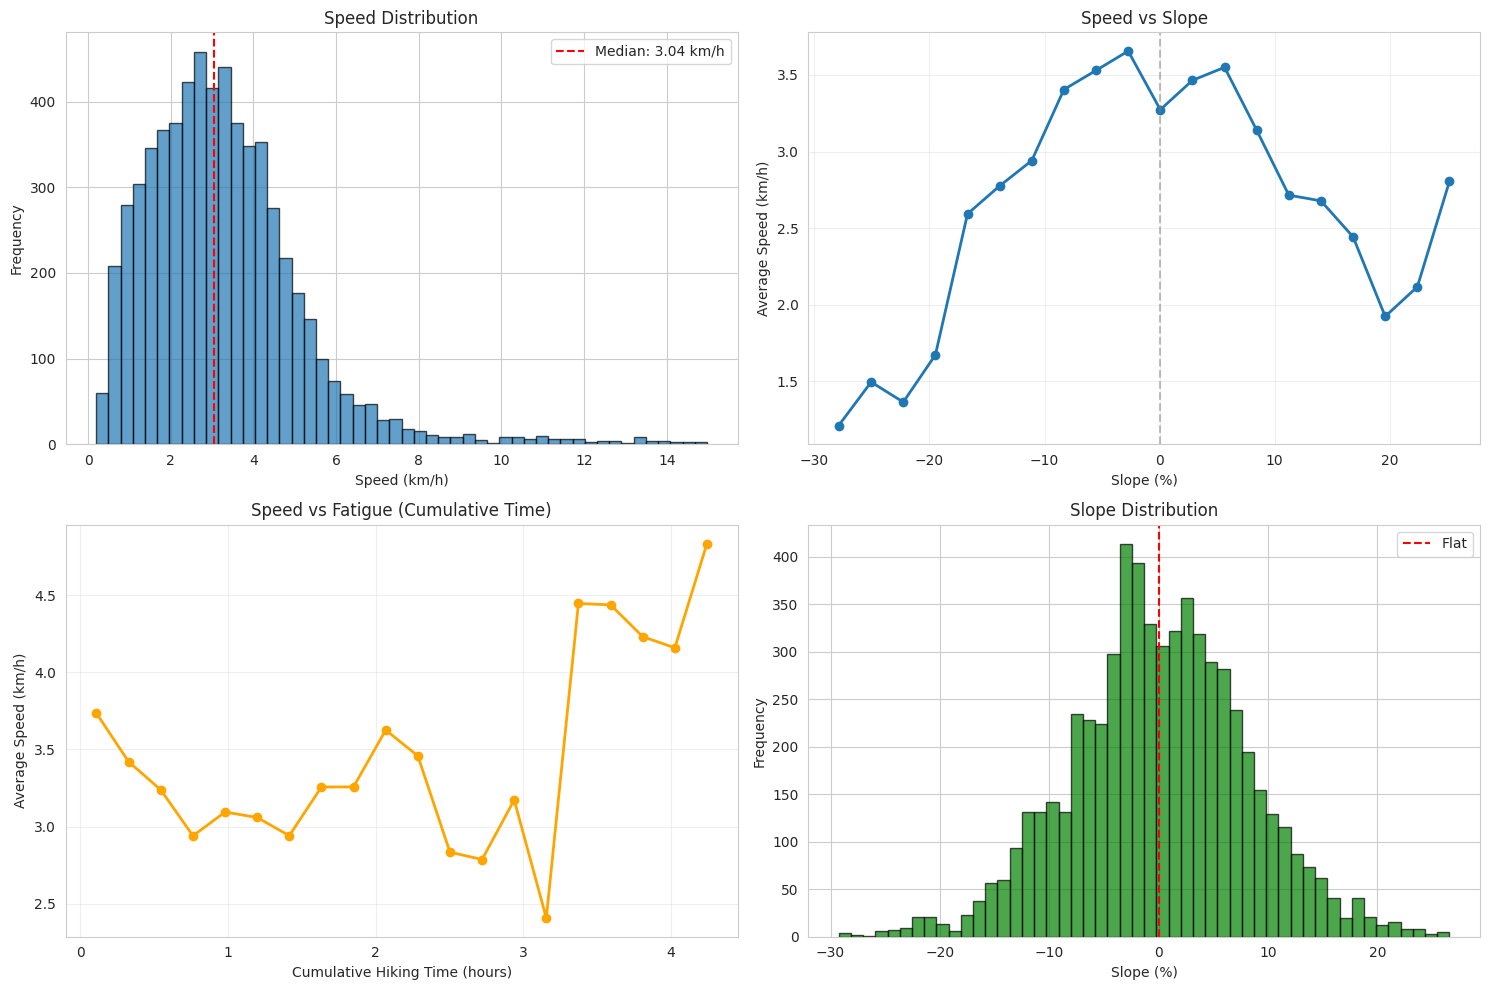

In [5]:
if hiking_metrics is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Speed distribution
    axes[0, 0].hist(hiking_metrics['speed_kmh'], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Speed (km/h)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Speed Distribution')
    axes[0, 0].axvline(hiking_metrics['speed_kmh'].median(), color='red', linestyle='--', label=f'Median: {hiking_metrics["speed_kmh"].median():.2f} km/h')
    axes[0, 0].legend()
    
    # Speed vs Slope
    # Bin slope for better visualization
    slope_bins = pd.cut(hiking_metrics['slope_percent'], bins=20)
    slope_speed = hiking_metrics.groupby(slope_bins)['speed_kmh'].mean()
    slope_centers = [interval.mid for interval in slope_speed.index]
    axes[0, 1].plot(slope_centers, slope_speed.values, marker='o', linewidth=2)
    axes[0, 1].set_xlabel('Slope (%)')
    axes[0, 1].set_ylabel('Average Speed (km/h)')
    axes[0, 1].set_title('Speed vs Slope')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axvline(0, color='gray', linestyle='--', alpha=0.5)
    
    # Speed vs Cumulative Time (fatigue effect)
    time_bins = pd.cut(hiking_metrics['cumulative_hours'], bins=20)
    time_speed = hiking_metrics.groupby(time_bins)['speed_kmh'].mean()
    time_centers = [interval.mid for interval in time_speed.index]
    axes[1, 0].plot(time_centers, time_speed.values, marker='o', linewidth=2, color='orange')
    axes[1, 0].set_xlabel('Cumulative Hiking Time (hours)')
    axes[1, 0].set_ylabel('Average Speed (km/h)')
    axes[1, 0].set_title('Speed vs Fatigue (Cumulative Time)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Slope distribution
    axes[1, 1].hist(hiking_metrics['slope_percent'], bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[1, 1].set_xlabel('Slope (%)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Slope Distribution')
    axes[1, 1].axvline(0, color='red', linestyle='--', label='Flat')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

In [6]:
# Analyze descent performance (knee problems)
if hiking_metrics is not None:
    descents = hiking_metrics[hiking_metrics['slope_percent'] < -5].copy()
    ascents = hiking_metrics[hiking_metrics['slope_percent'] > 5].copy()
    flat = hiking_metrics[abs(hiking_metrics['slope_percent']) <= 5].copy()
    
    print("Performance by terrain type:\n")
    print(f"Flat terrain (±5%):")
    print(f"  Average speed: {flat['speed_kmh'].mean():.2f} km/h")
    print(f"  Median speed: {flat['speed_kmh'].median():.2f} km/h\n")
    
    print(f"Ascents (>5%):")
    print(f"  Average speed: {ascents['speed_kmh'].mean():.2f} km/h")
    print(f"  Median speed: {ascents['speed_kmh'].median():.2f} km/h\n")
    
    print(f"Descents (<-5%):")
    print(f"  Average speed: {descents['speed_kmh'].mean():.2f} km/h")
    print(f"  Median speed: {descents['speed_kmh'].median():.2f} km/h\n")
    
    # Analyze descent speed degradation with fatigue
    print("Descent speed by fatigue level:\n")
    for hours in [0, 2, 4, 6, 8]:
        subset = descents[(descents['cumulative_hours'] >= hours) & (descents['cumulative_hours'] < hours + 2)]
        if len(subset) > 0:
            print(f"  {hours}-{hours+2}h: {subset['speed_kmh'].mean():.2f} km/h (n={len(subset)})")

Performance by terrain type:

Flat terrain (±5%):
  Average speed: 3.52 km/h
  Median speed: 3.28 km/h

Ascents (>5%):
  Average speed: 3.00 km/h
  Median speed: 2.77 km/h

Descents (<-5%):
  Average speed: 3.08 km/h
  Median speed: 2.83 km/h

Descent speed by fatigue level:

  0-2h: 2.96 km/h (n=937)
  2-4h: 3.27 km/h (n=579)


## 4. Build Speed Prediction Model

We'll use a Gradient Boosting model to predict speed based on:
- Slope percentage
- Cumulative hiking hours (fatigue)
- Interaction between slope and fatigue (especially for descents with knee issues)

In [7]:
def prepare_features(df):
    """
    Prepare features for the prediction model.
    """
    features_df = df.copy()
    
    # Basic features
    features_df['slope'] = features_df['slope_percent']
    features_df['fatigue'] = features_df['cumulative_hours']
    
    # Separate uphill and downhill slopes
    features_df['uphill'] = features_df['slope'].apply(lambda x: max(0, x))
    features_df['downhill'] = features_df['slope'].apply(lambda x: abs(min(0, x)))
    
    # Fatigue interaction terms (knee problems worsen with fatigue on descents)
    features_df['downhill_fatigue'] = features_df['downhill'] * features_df['fatigue']
    features_df['uphill_fatigue'] = features_df['uphill'] * features_df['fatigue']
    
    # Quadratic terms to capture non-linear effects
    features_df['slope_squared'] = features_df['slope'] ** 2
    features_df['fatigue_squared'] = features_df['fatigue'] ** 2
    
    return features_df


if hiking_metrics is not None:
    # Prepare data
    model_data = prepare_features(hiking_metrics)
    
    # Define features and target
    feature_cols = ['slope', 'fatigue', 'uphill', 'downhill', 
                    'downhill_fatigue', 'uphill_fatigue', 
                    'slope_squared', 'fatigue_squared']
    
    X = model_data[feature_cols]
    y = model_data['speed_kmh']
    
    # Split data: use 80% for training, 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    model = GradientBoostingRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Evaluate model
    train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print("Model Performance:")
    print(f"\nTraining Set:")
    print(f"  R² Score: {train_r2:.4f}")
    print(f"  MAPE: {train_mape:.2f}%")
    print(f"\nTest Set:")
    print(f"  R² Score: {test_r2:.4f}")
    print(f"  MAPE: {test_mape:.2f}%")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    display(feature_importance)
    
    # Add predictions to the dataframe
    model_data['predicted_speed_kmh'] = model.predict(X)
    model_data['prediction_error_pct'] = abs(model_data['speed_kmh'] - model_data['predicted_speed_kmh']) / model_data['speed_kmh'] * 100

Model Performance:

Training Set:
  R² Score: 0.3712
  MAPE: 55.82%

Test Set:
  R² Score: 0.0782
  MAPE: 68.53%

Feature Importance:


,feature,importance
7,fatigue_squared,0.219669
6,slope_squared,0.218574
1,fatigue,0.216716
5,uphill_fatigue,0.110611
4,downhill_fatigue,0.095877
0,slope,0.075953
2,uphill,0.031921
3,downhill,0.030679


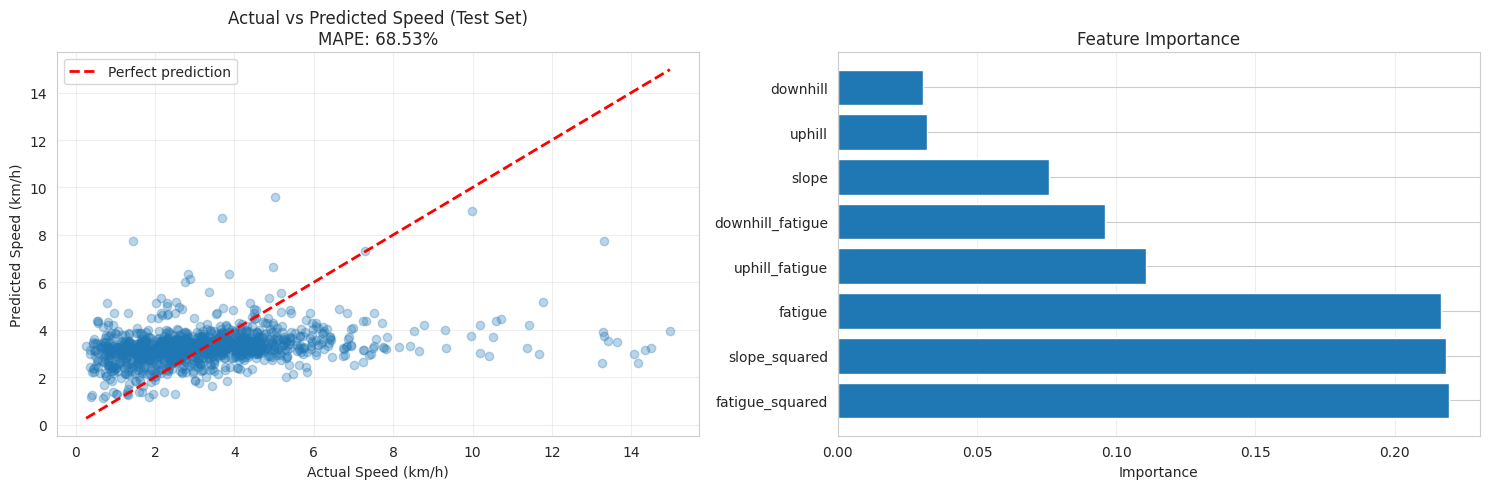

In [8]:
# Visualize model performance
if hiking_metrics is not None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Actual vs Predicted
    axes[0].scatter(y_test, y_pred_test, alpha=0.3)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
    axes[0].set_xlabel('Actual Speed (km/h)')
    axes[0].set_ylabel('Predicted Speed (km/h)')
    axes[0].set_title(f'Actual vs Predicted Speed (Test Set)\nMAPE: {test_mape:.2f}%')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Feature importance
    axes[1].barh(feature_importance['feature'], feature_importance['importance'])
    axes[1].set_xlabel('Importance')
    axes[1].set_title('Feature Importance')
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

## 5. Validate Model on Complete Tracks

Apply the model to entire tracks and compare predicted vs actual hiking times.

In [9]:
def validate_on_tracks(df, model, feature_cols):
    """
    Validate the model by predicting total time for each track and comparing to actual time.
    """
    results = []
    
    for track_name in df['track_name'].unique():
        track_data = df[df['track_name'] == track_name].copy()
        
        # Group by date to handle multi-day hikes
        for date in track_data['date'].unique():
            day_data = track_data[track_data['date'] == date].copy()
            
            # Actual metrics
            actual_time_hours = day_data['time_delta_s'].sum() / 3600
            actual_distance_km = day_data['distance_m'].sum() / 1000
            
            if actual_time_hours < 0.5:  # Skip very short segments
                continue
            
            # Predict speed for each segment
            X_pred = day_data[feature_cols]
            predicted_speeds_kmh = model.predict(X_pred)
            
            # Calculate predicted time for each segment
            day_data['predicted_time_hours'] = (day_data['distance_m'] / 1000) / predicted_speeds_kmh
            predicted_time_hours = day_data['predicted_time_hours'].sum()
            
            # Calculate error
            time_error_pct = abs(predicted_time_hours - actual_time_hours) / actual_time_hours * 100
            
            results.append({
                'track_name': track_name,
                'date': date,
                'actual_time_hours': actual_time_hours,
                'predicted_time_hours': predicted_time_hours,
                'distance_km': actual_distance_km,
                'time_error_pct': time_error_pct,
                'elevation_gain_m': day_data[day_data['elevation_change_m'] > 0]['elevation_change_m'].sum(),
                'elevation_loss_m': abs(day_data[day_data['elevation_change_m'] < 0]['elevation_change_m'].sum())
            })
    
    return pd.DataFrame(results)


if hiking_metrics is not None:
    validation_results = validate_on_tracks(model_data, model, feature_cols)
    
    print("Track Validation Results:\n")
    display(validation_results)
    
    # Check if model meets 15% accuracy requirement
    avg_error = validation_results['time_error_pct'].mean()
    within_15pct = (validation_results['time_error_pct'] <= 15).sum()
    total_tracks = len(validation_results)
    
    print(f"\n{'='*60}")
    print(f"VALIDATION SUMMARY")
    print(f"{'='*60}")
    print(f"Average prediction error: {avg_error:.2f}%")
    print(f"Tracks within 15% accuracy: {within_15pct}/{total_tracks} ({within_15pct/total_tracks*100:.1f}%)")
    
    if avg_error <= 15:
        print(f"\n✓ Model PASSES validation (average error ≤ 15%)")
    else:
        print(f"\n✗ Model FAILS validation (average error > 15%)")
        print(f"  Consider collecting more data or adjusting model parameters.")

Track Validation Results:



,track_name,date,actual_time_hours,predicted_time_hours,distance_km,time_error_pct,elevation_gain_m,elevation_loss_m
0,Rando corbeau ouareau,2025-08-23,7.259167,6.068739,19.458314,16.398960,665.211575,603.360571
1,Rando corbeau ouareau,2025-08-24,1.646389,1.450839,4.858726,11.877515,78.996808,155.243249
2,Rando Mont-Gorille,2025-10-30,5.106389,3.576150,9.477019,29.967149,463.161771,459.425304
3,Rando Mont-Gorille,2025-10-31,4.352222,3.073064,10.620713,29.390918,319.161296,322.248979



VALIDATION SUMMARY
Average prediction error: 21.91%
Tracks within 15% accuracy: 1/4 (25.0%)

✗ Model FAILS validation (average error > 15%)
  Consider collecting more data or adjusting model parameters.


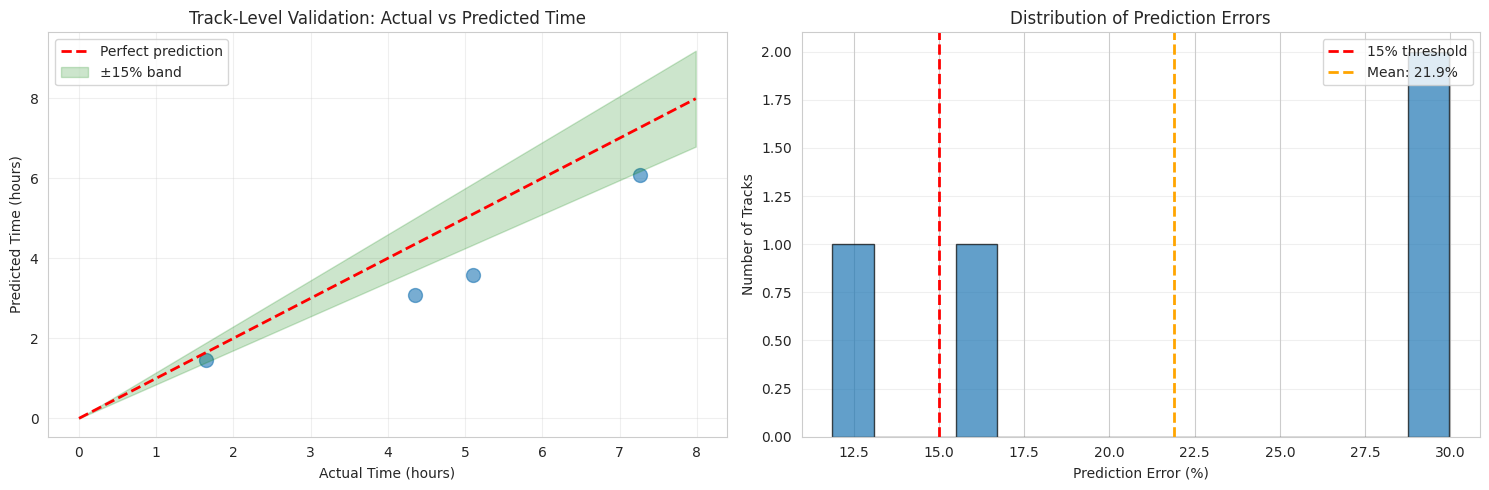

In [10]:
# Visualize validation results
if hiking_metrics is not None and len(validation_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Actual vs Predicted time
    axes[0].scatter(validation_results['actual_time_hours'], 
                    validation_results['predicted_time_hours'], 
                    s=100, alpha=0.6)
    
    # Add ±15% error bands
    x_range = np.linspace(0, validation_results['actual_time_hours'].max() * 1.1, 100)
    axes[0].plot(x_range, x_range, 'r--', lw=2, label='Perfect prediction')
    axes[0].fill_between(x_range, x_range * 0.85, x_range * 1.15, alpha=0.2, color='green', label='±15% band')
    
    axes[0].set_xlabel('Actual Time (hours)')
    axes[0].set_ylabel('Predicted Time (hours)')
    axes[0].set_title('Track-Level Validation: Actual vs Predicted Time')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Error distribution
    axes[1].hist(validation_results['time_error_pct'], bins=15, edgecolor='black', alpha=0.7)
    axes[1].axvline(15, color='red', linestyle='--', lw=2, label='15% threshold')
    axes[1].axvline(validation_results['time_error_pct'].mean(), color='orange', linestyle='--', lw=2, label=f'Mean: {validation_results["time_error_pct"].mean():.1f}%')
    axes[1].set_xlabel('Prediction Error (%)')
    axes[1].set_ylabel('Number of Tracks')
    axes[1].set_title('Distribution of Prediction Errors')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

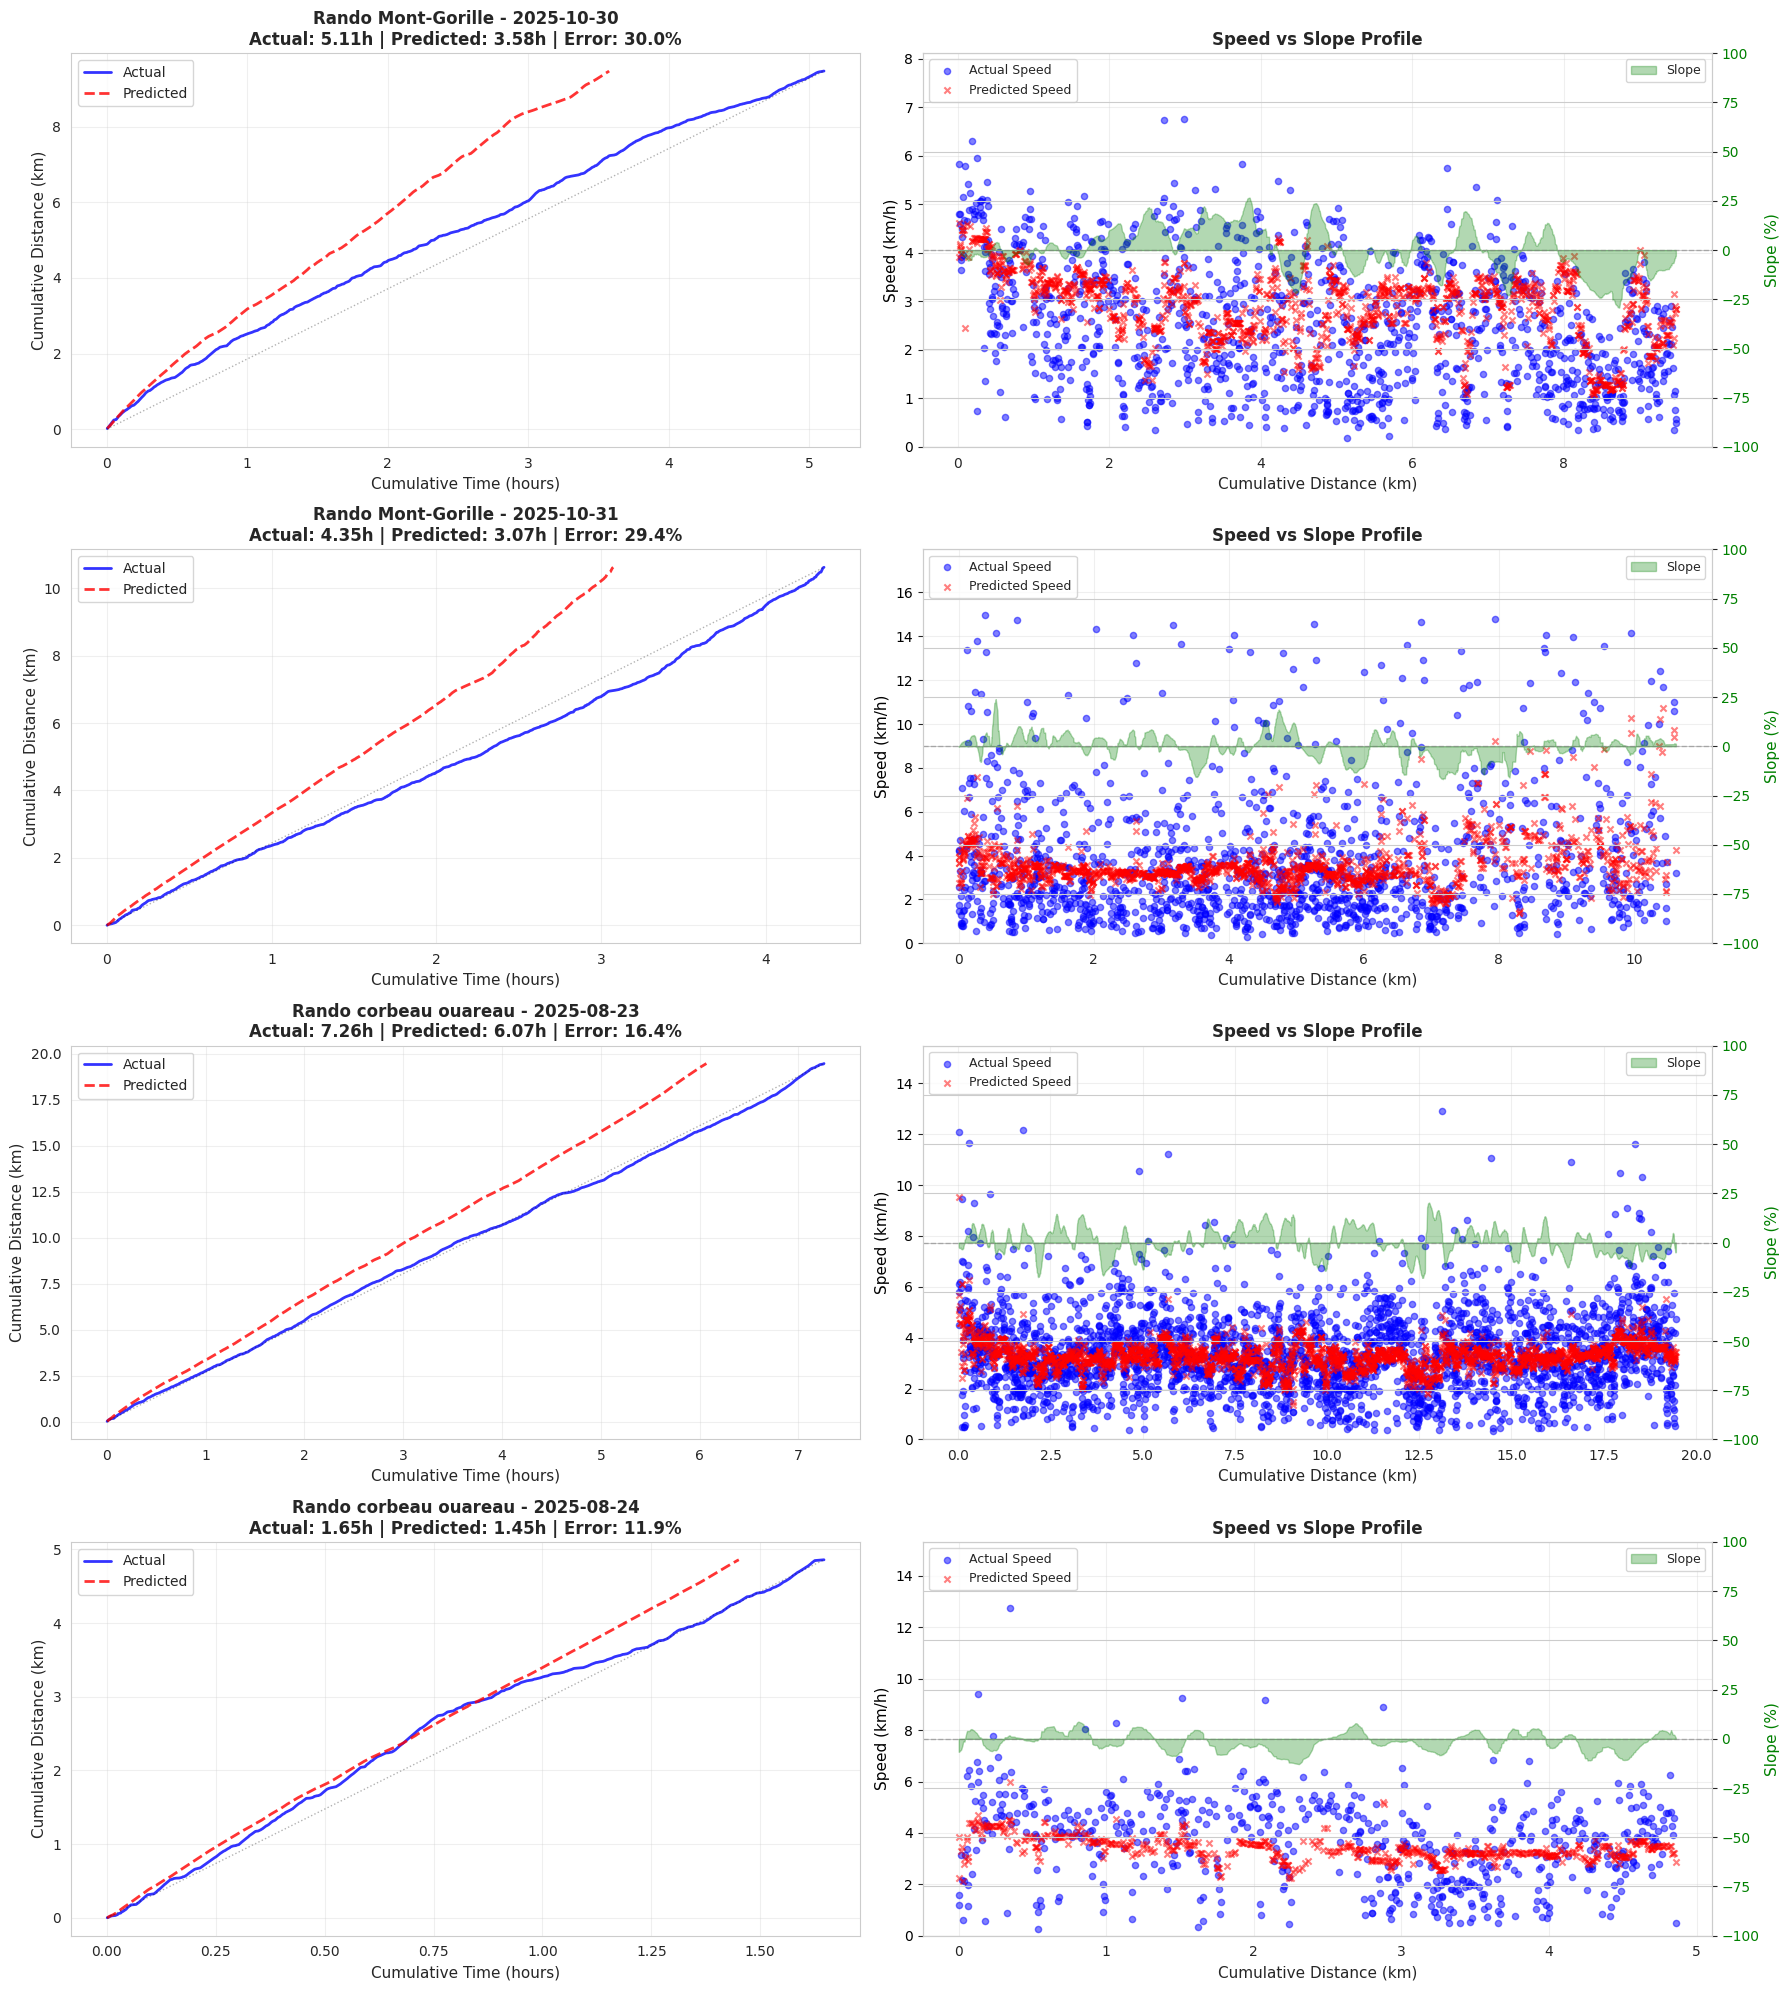


MODEL ERROR ANALYSIS BY TERRAIN TYPE

Speed Error by Terrain Type:
(Positive error = model overestimates speed)
              speed_error_pct               speed_kmh predicted_speed
                         mean     std count      mean            mean
terrain_type                                                         
Steep Descent           29.12   62.87    71      1.37            1.43
Descent                 34.11   97.02  1445      3.16            3.17
Flat                    40.35  110.54  2991      3.52            3.52
Ascent                  35.80   96.69  1565      3.03            3.03
Steep Ascent            29.51   79.88    48      2.28            2.10


Speed Error by Fatigue Level:
                 speed_error_pct               speed_kmh predicted_speed
                            mean     std count      mean            mean
fatigue_level                                                           
Fresh (0-1h)               38.52  108.45  2414      3.32            3.32
Mod

In [11]:
def plot_track_analysis(df, model, feature_cols):
    """
    Plot detailed track-by-track analysis showing predicted vs actual distance over time,
    with slope information to identify model weaknesses.
    """
    # Get unique track/date combinations
    track_dates = df.groupby(['track_name', 'date']).size().reset_index()[['track_name', 'date']]
    
    # Create subplots - one row per track
    n_tracks = len(track_dates)
    fig, axes = plt.subplots(n_tracks, 2, figsize=(18, 5*n_tracks))
    
    # Handle single track case
    if n_tracks == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (_, row) in enumerate(track_dates.iterrows()):
        track_name = row['track_name']
        date = row['date']
        
        # Get data for this track/date
        track_data = df[(df['track_name'] == track_name) & (df['date'] == date)].copy()
        
        if len(track_data) == 0:
            continue
        
        # Calculate cumulative distance (actual)
        track_data['cumulative_distance_km'] = track_data['distance_m'].cumsum() / 1000
        
        # Calculate predicted time for each segment
        X_pred = track_data[feature_cols]
        predicted_speeds = model.predict(X_pred)
        track_data['predicted_time_s'] = (track_data['distance_m'] / 1000) / predicted_speeds * 3600
        
        # Calculate cumulative times
        track_data['cumulative_actual_time_h'] = track_data['time_delta_s'].cumsum() / 3600
        track_data['cumulative_predicted_time_h'] = track_data['predicted_time_s'].cumsum() / 3600
        
        # LEFT PLOT: Distance over Time
        ax1 = axes[idx, 0]
        
        # Plot actual and predicted
        ax1.plot(track_data['cumulative_actual_time_h'], 
                track_data['cumulative_distance_km'], 
                'b-', linewidth=2, label='Actual', alpha=0.8)
        ax1.plot(track_data['cumulative_predicted_time_h'], 
                track_data['cumulative_distance_km'], 
                'r--', linewidth=2, label='Predicted', alpha=0.8)
        
        # Add diagonal reference line (perfect prediction would overlap)
        ax1.plot([0, track_data['cumulative_actual_time_h'].max()],
                [0, track_data['cumulative_distance_km'].max()],
                'k:', linewidth=1, alpha=0.3)
        
        ax1.set_xlabel('Cumulative Time (hours)', fontsize=11)
        ax1.set_ylabel('Cumulative Distance (km)', fontsize=11)
        ax1.set_title(f'{track_name} - {date}\n' + 
                     f'Actual: {track_data["cumulative_actual_time_h"].iloc[-1]:.2f}h | ' +
                     f'Predicted: {track_data["cumulative_predicted_time_h"].iloc[-1]:.2f}h | ' +
                     f'Error: {abs(track_data["cumulative_actual_time_h"].iloc[-1] - track_data["cumulative_predicted_time_h"].iloc[-1]) / track_data["cumulative_actual_time_h"].iloc[-1] * 100:.1f}%',
                     fontsize=12, fontweight='bold')
        ax1.legend(loc='upper left', fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # RIGHT PLOT: Slope profile with speed comparison
        ax2 = axes[idx, 1]
        
        # Create twin axis for slope
        ax2_twin = ax2.twinx()
        
        # Plot speed (actual vs predicted) on left axis
        ax2.scatter(track_data['cumulative_distance_km'], 
                   track_data['speed_kmh'],
                   c='blue', alpha=0.5, s=20, label='Actual Speed')
        
        predicted_speed_segments = predicted_speeds
        ax2.scatter(track_data['cumulative_distance_km'], 
                   predicted_speed_segments,
                   c='red', alpha=0.5, s=20, marker='x', label='Predicted Speed')
        
        # Plot slope on right axis as filled area
        ax2_twin.fill_between(track_data['cumulative_distance_km'], 
                              0, track_data['slope_percent'],
                              alpha=0.3, color='green', label='Slope')
        ax2_twin.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        
        ax2.set_xlabel('Cumulative Distance (km)', fontsize=11)
        ax2.set_ylabel('Speed (km/h)', fontsize=11, color='black')
        ax2_twin.set_ylabel('Slope (%)', fontsize=11, color='green')
        ax2.set_title('Speed vs Slope Profile', fontsize=12, fontweight='bold')
        
        # Set y-axis limits for better visualization
        ax2.set_ylim(0, max(track_data['speed_kmh'].max(), predicted_speed_segments.max()) * 1.2)
        ax2_twin.set_ylim(-100, 100)
        
        ax2.legend(loc='upper left', fontsize=9)
        ax2_twin.legend(loc='upper right', fontsize=9)
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='y', labelcolor='black')
        ax2_twin.tick_params(axis='y', labelcolor='green')
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: where is the model wrong?
    print("\n" + "="*80)
    print("MODEL ERROR ANALYSIS BY TERRAIN TYPE")
    print("="*80)
    
    # Analyze prediction errors by slope category
    df['predicted_speed'] = model.predict(df[feature_cols])
    df['speed_error_pct'] = (df['predicted_speed'] - df['speed_kmh']) / df['speed_kmh'] * 100
    
    # Categorize by slope
    df['terrain_type'] = pd.cut(df['slope_percent'], 
                                 bins=[-np.inf, -20, -5, 5, 20, np.inf],
                                 labels=['Steep Descent', 'Descent', 'Flat', 'Ascent', 'Steep Ascent'])
    
    # Categorize by fatigue
    df['fatigue_level'] = pd.cut(df['cumulative_hours'],
                                  bins=[0, 1, 2, 3, np.inf],
                                  labels=['Fresh (0-1h)', 'Moderate (1-2h)', 'Tired (2-3h)', 'Very Tired (>3h)'])
    
    print("\nSpeed Error by Terrain Type:")
    print("(Positive error = model overestimates speed)")
    terrain_analysis = df.groupby('terrain_type').agg({
        'speed_error_pct': ['mean', 'std', 'count'],
        'speed_kmh': 'mean',
        'predicted_speed': 'mean'
    }).round(2)
    print(terrain_analysis)
    
    print("\n\nSpeed Error by Fatigue Level:")
    fatigue_analysis = df.groupby('fatigue_level').agg({
        'speed_error_pct': ['mean', 'std', 'count'],
        'speed_kmh': 'mean',
        'predicted_speed': 'mean'
    }).round(2)
    print(fatigue_analysis)
    
    print("\n\nSpeed Error by Terrain × Fatigue:")
    combined_analysis = df.groupby(['terrain_type', 'fatigue_level'])['speed_error_pct'].mean().round(2)
    print(combined_analysis)
    
    return df


# Run the detailed analysis
if hiking_metrics is not None:
    analyzed_df = plot_track_analysis(model_data, model, feature_cols)

## 5.1 Detailed Track Analysis: Distance Over Time with Slope

This visualization shows predicted vs actual cumulative distance over time for each track, with slope information to identify which parameters are undervalued.

## 6. Use the Model for Future Hike Planning

You can now use this model to predict how long a planned route will take!

In [12]:
def predict_hike_time(route_gpx_path, model, feature_cols):
    """
    Predict the time needed for a planned route.
    
    Args:
        route_gpx_path: Path to the GPX file of your planned route
        model: Trained prediction model
        feature_cols: List of feature column names
    """
    # Load route
    route_df = parse_gpx_file(Path(route_gpx_path))
    
    # Calculate route metrics (without timestamps, so we'll use sequential processing)
    route_segments = []
    cumulative_time = 0
    
    for i in range(len(route_df) - 1):
        p1 = route_df.iloc[i]
        p2 = route_df.iloc[i + 1]
        
        # Calculate distance
        coord1 = (p1['latitude'], p1['longitude'])
        coord2 = (p2['latitude'], p2['longitude'])
        distance_m = geodesic(coord1, coord2).meters
        
        if distance_m < 1:
            continue
        
        # Calculate elevation change and slope
        elev_change_m = p2['elevation'] - p1['elevation'] if (p1['elevation'] and p2['elevation']) else 0
        slope_percent = (elev_change_m / distance_m * 100) if distance_m > 0 else 0
        
        route_segments.append({
            'distance_m': distance_m,
            'slope_percent': slope_percent,
            'cumulative_hours': cumulative_time,
            'elevation_change_m': elev_change_m
        })
    
    route_metrics_df = pd.DataFrame(route_segments)
    route_metrics_df = prepare_features(route_metrics_df)
    
    # Predict speeds
    X_route = route_metrics_df[feature_cols]
    predicted_speeds = model.predict(X_route)
    
    # Calculate time for each segment and update cumulative time
    for i, speed_kmh in enumerate(predicted_speeds):
        segment_time_hours = (route_metrics_df.iloc[i]['distance_m'] / 1000) / speed_kmh
        route_metrics_df.loc[i, 'predicted_time_hours'] = segment_time_hours
        
        # Update cumulative time for next segment
        if i < len(route_metrics_df) - 1:
            route_metrics_df.loc[i + 1, 'cumulative_hours'] = route_metrics_df.loc[i, 'cumulative_hours'] + segment_time_hours
    
    # Summary
    total_distance_km = route_metrics_df['distance_m'].sum() / 1000
    total_time_hours = route_metrics_df['predicted_time_hours'].sum()
    total_elevation_gain = route_metrics_df[route_metrics_df['elevation_change_m'] > 0]['elevation_change_m'].sum()
    total_elevation_loss = abs(route_metrics_df[route_metrics_df['elevation_change_m'] < 0]['elevation_change_m'].sum())
    
    print(f"\n{'='*60}")
    print(f"PREDICTED HIKE TIME FOR: {Path(route_gpx_path).stem}")
    print(f"{'='*60}")
    print(f"Total Distance: {total_distance_km:.2f} km")
    print(f"Elevation Gain: {total_elevation_gain:.0f} m")
    print(f"Elevation Loss: {total_elevation_loss:.0f} m")
    print(f"\nPredicted Time: {total_time_hours:.2f} hours ({int(total_time_hours)}h {int((total_time_hours % 1) * 60)}min)")
    print(f"Average Speed: {total_distance_km / total_time_hours:.2f} km/h")
    print(f"\nRecommended buffer (+20%): {total_time_hours * 1.2:.2f} hours ({int(total_time_hours * 1.2)}h {int((total_time_hours * 1.2 % 1) * 60)}min)")
    print(f"{'='*60}\n")
    
    return route_metrics_df, total_time_hours


# Example usage:
# Uncomment and modify the path below to predict time for a planned route
# route_prediction, predicted_time = predict_hike_time('gaiagps_tracks/my_planned_route.gpx', model, feature_cols)

## 7. Export the Model

Save the model for future use without retraining.

In [13]:
import pickle

if hiking_metrics is not None:
    # Save model and feature columns
    model_data_to_save = {
        'model': model,
        'feature_cols': feature_cols,
        'training_stats': {
            'test_mape': test_mape,
            'test_r2': test_r2,
            'avg_track_error': validation_results['time_error_pct'].mean()
        }
    }
    
    with open('hiking_speed_model.pkl', 'wb') as f:
        pickle.dump(model_data_to_save, f)
    
    print("Model saved to 'hiking_speed_model.pkl'")
    print("\nTo load the model in the future:")
    print("""\nimport pickle
with open('hiking_speed_model.pkl', 'rb') as f:
    saved_data = pickle.load(f)
    model = saved_data['model']
    feature_cols = saved_data['feature_cols']
""")

Model saved to 'hiking_speed_model.pkl'

To load the model in the future:

import pickle
with open('hiking_speed_model.pkl', 'rb') as f:
    saved_data = pickle.load(f)
    model = saved_data['model']
    feature_cols = saved_data['feature_cols']



## Summary & Next Steps

This notebook:
1. ✓ Fetches and parses your recorded tracks from GaiaGPS (via GPX export)
2. ✓ Analyzes slope, fatigue, and speed relationships
3. ✓ Builds a personalized speed prediction model
4. ✓ Accounts for knee problems on descents and fatigue effects
5. ✓ Validates the model against actual tracks (target: ±15% accuracy)
6. ✓ Provides a function to predict time for future planned routes

### Next Steps:

1. **Export your GaiaGPS tracks**: Go to gaiagps.com and export all your tracks from last year as GPX files
2. **Run the notebook**: Place GPX files in `gaiagps_tracks/` folder and run all cells
3. **Review validation**: Check if the model meets the 15% accuracy target
4. **Use for planning**: Export your planned routes and use `predict_hike_time()` to estimate duration

### Tips:
- The model automatically handles multi-day hikes
- Add more historical tracks to improve accuracy
- Consider adding a 20% buffer to predictions for safety
- The model learns your specific patterns (knee issues, fatigue rate, etc.)

**Sources:**
- [Export Data as GPX, KML, or GeoJSON from gaiagps.com](https://help.gaiagps.com/hc/en-us/articles/115003524687-Export-Data-as-GPX-KML-or-GeoJSON-from-gaiagps-com)
- [GaiaGPS Python Client](https://github.com/kk7ds/gaiagpsclient)
- [Python API Documentation — GaiaGPS Python Client](https://gaiagpsclient.readthedocs.io/en/latest/gaiagps.html)